# Subcluster & NMF
- subset tumor cells and re-integrate with `scVI` or `cellanova`
- include normal OPC

In [1]:
import os
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

# scRNA-seq analysis pipeline
import scanpy as sc
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import mplscience
%matplotlib inline

# Models & Calculation
import scvi
from scvi import autotune
from ray import tune
import ray
import torch
import mygene

ModuleNotFoundError: No module named 'scvi'

In [2]:
adata = sc.read_h5ad('../output/annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 53408 × 29009
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    uns: 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

In [3]:
adata = adata[adata.obs['cell_type'].isin(['Tumor'])].copy()
adata

AnnData object with n_obs × n_vars = 13249 × 29009
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    uns: 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

In [4]:
del adata.layers['log1p']
del adata.obsm

In [5]:
adata.write('../output/annotated_subcluster_tumor.h5ad')

## 2. Filter genes only with expression level

In [5]:
adata = sc.read_h5ad('../output/annotated_subcluster_tumor.h5ad')
adata

AnnData object with n_obs × n_vars = 13249 × 29009
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    uns: 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [6]:
sc.pp.filter_genes(adata, min_cells = int(adata.shape[0]*0.05))
adata

AnnData object with n_obs × n_vars = 13249 × 12431
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    var: 'n_cells'
    uns: 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [7]:
scvi.model.SCVI.setup_anndata(adata, layer = 'counts', batch_key = 'sample_id', continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])
model_scvi = scvi.model.SCVI(adata, n_layers=2)

In [8]:
model_scvi.train(early_stopping=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
model_scvi.save('../output/model_scvi_subcluster_all_tumor')

In [ ]:
model_scvi = scvi.model.SCVI.load('../output/model_scvi_subcluster_all_tumor', adata)

INFO     File ../output/model_scvi_subcluster_all/model.pt already downloaded                                      


In [33]:
adata.X = adata.layers['counts'].toarray()
adata.obsm['X_scVI'] = model_scvi.get_latent_representation()
adata.layers['scvi_normalized'] = model_scvi.get_normalized_expression(library_size=1e6) # tpm
adata.write('../output/subcluster.h5ad')

In [34]:
adata.X = adata.layers['scvi_normalized'].copy()
adata.write_h5ad('../output/subcluster_scvi.h5ad')

In [24]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, layer = 'counts', flavor = 'seurat_v3', batch_key = 'sample_id') 

with open('../output/hvgs.txt', 'w') as f:
    for gene in adata.var_names:
        f.write(gene + '\n')

# Run cNMF cli
- numpy < 2

In [ ]:
cnmf prepare --output-dir cNMF --name subcluster \
-c subcluster_tumor.h5ad --tpm subcluster_tumor_scvi.h5ad --genes-file=hvgs.txt \
-k 2 3 4 5 6 7 8 9 10 11 12 --n-iter 1000 --total-workers 72 --seed 777 --numgenes 2000

In [ ]:
parallel cnmf factorize --output-dir cNMF --name subcluster --total-workers 2 --worker-index {} ::: $(seq 0 1)

In [ ]:
cnmf combine --output-dir cNMF --name subcluster --total-workers 72

In [ ]:
cnmf k_selection_plot --output-dir cNMF --name subcluster --total-workers 72

In [ ]:
cnmf consensus --output-dir cNMF --name subcluster --components 6 --local-density-threshold 2.0 --show-clustering --total-workers 72

In [ ]:
cnmf consensus --output-dir cNMF --name subcluster --components 6 --local-density-threshold 0.5 --show-clustering --total-workers 72

In [ ]:
rm cNMF/subcluster/cnmf_tmp/subcluster.spectra.k_*.iter_*.df.npz

# cNMF downstream

In [2]:
import os
import warnings
warnings.simplefilter('ignore')
from cnmf import cNMF
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplscience

from scipy.cluster.hierarchy import leaves_list, linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

In [3]:
plot_path = '../plot'
output_path = '../output'

In [4]:
adata = sc.read_h5ad('../output/tumor_only/subcluster_tumor.h5ad')
adata

AnnData object with n_obs × n_vars = 13249 × 12431
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type', '_scvi_batch', '_scvi_labels'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_scVI', '_scvi_extra_continuous_covs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [5]:
cnmf_obj = cNMF(output_dir = '../output/tumor_only/cNMF', name = 'subcluster')
usage_norm, gep_scores, gep_tpm, topgenes = cnmf_obj.load_results(K=6, density_threshold=0.5)
usage_norm.columns = [f'NMF_Module_{i}' for i in usage_norm.columns]

In [6]:
adata.shape, usage_norm.shape, gep_scores.shape, gep_tpm.shape, topgenes.shape

((13249, 12431), (13249, 6), (12431, 6), (12431, 6), (100, 6))

In [7]:
adata.obs = pd.merge(left = adata.obs, right = usage_norm, left_index = True, right_index = True, how = 'left')

In [8]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata)

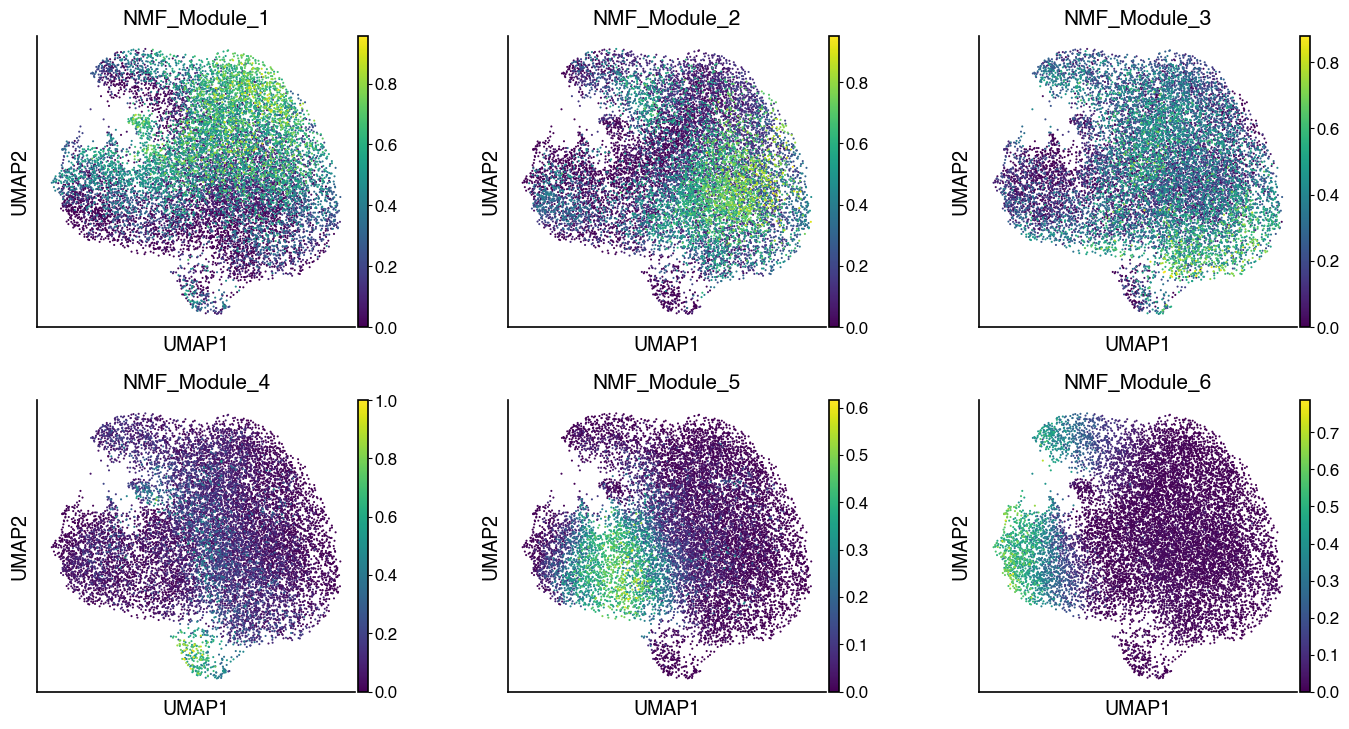

In [9]:
with mplscience.style_context():
    sc.pl.umap(adata, color = list(usage_norm.columns) , ncols = 3, wspace=0.35, show = False)
    plt.show()

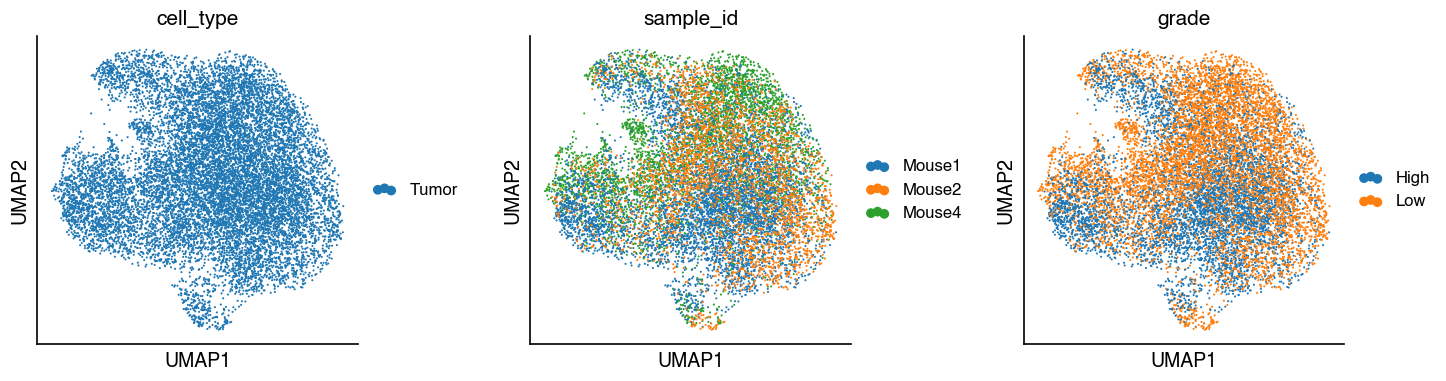

In [11]:
with mplscience.style_context():
    sc.pl.umap(adata, color = ['cell_type', 'sample_id', 'grade'], show = False, wspace=0.4, ncols = 3)
    # plt.savefig(os.path.join(plot_path, 'Fig4D_GEP(NMF)_sample+grade.pdf'), dpi = 300, format = 'pdf', bbox_inches='tight')
    plt.show()

## 1. Heatmap

In [14]:
top = [item for sublist in [topgenes[col].values.tolist() for col in topgenes.columns] for item in sublist]

# Option 1 : select top gene
i = 1 # number of gene to display per module
selected_genes = [item for sublist in [topgenes[col][:i,].values.tolist() for col in topgenes.columns] for item in sublist]

# Option 2 : select famous genes
# selected_genes = ["Rps25", "Eif3e",
#                   "Dpp6", "Ntm",
#                   "Rgs7", "Enox1",
#                   "Egr1", "Fos",
#                   "Msn", "Vcam1",
#                   "Cdc45", "Cdk2",
#                   "Cenpe", "Mki67",
#                   "Mbp", "Mag"
#                   ]
matrix = gep_scores.loc[top, :]

yticklabels = [gene if gene in selected_genes else '' for gene in matrix.index]
xticklabels = [gene if gene in selected_genes else '' for gene in matrix.index]
dist_matrix = pdist(matrix)
dist_square_matrix = squareform(dist_matrix)
linkage_matrix = linkage(dist_matrix, method='average')

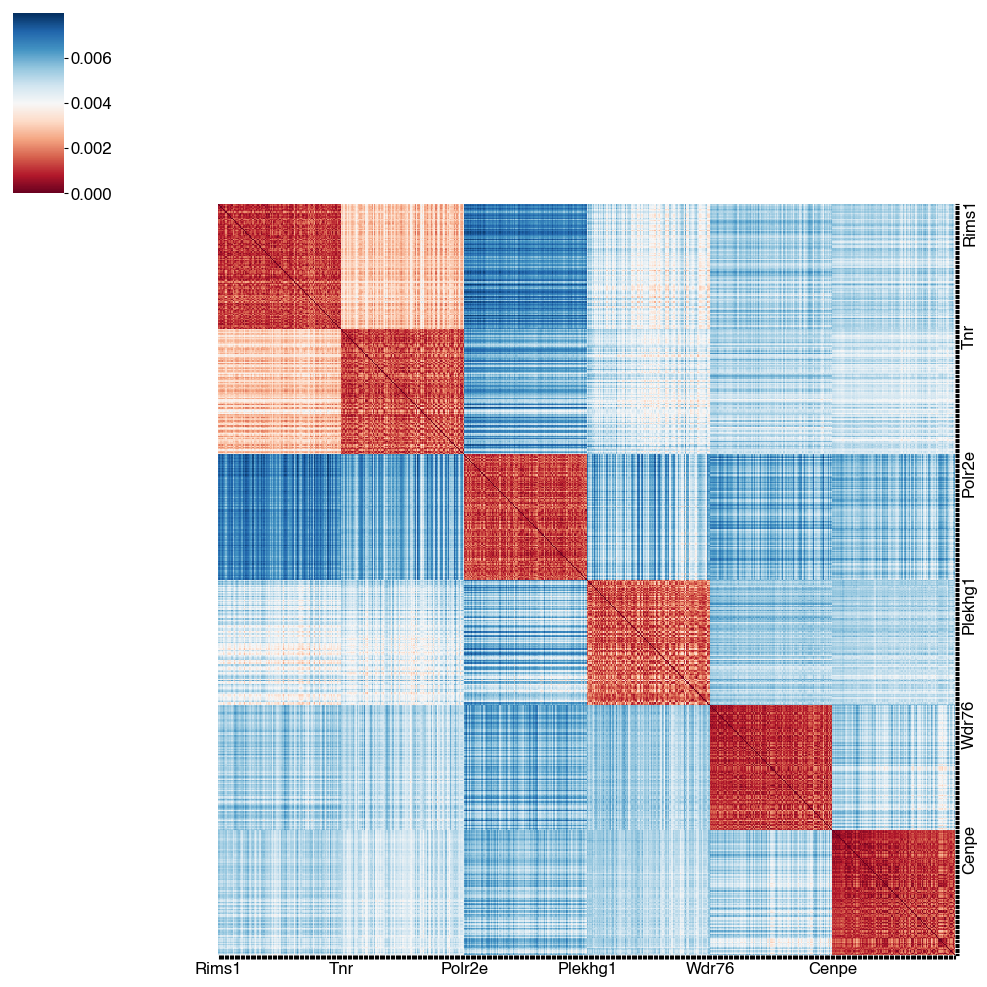

In [15]:
with mplscience.style_context(reset_current=True):
    g = sns.clustermap(dist_square_matrix, 
                row_cluster=False, 
                col_cluster=False, 
                cmap='RdBu', 
                xticklabels=xticklabels, 
                yticklabels=yticklabels, 
                rasterized=True,
                )
    ax = g.ax_heatmap
    ax.spines['right'].set_linewidth(0)
    ax.spines['bottom'].set_linewidth(0)
    ax.spines['left'].set_linewidth(0)
    ax.spines['top'].set_linewidth(0)

    # plt.savefig(os.path.join(plot_path, f'Fig4D_Heatmap(NMF)_keeporder.pdf'), dpi = 300, format = 'pdf', bbox_inches='tight')
    plt.show()

In [16]:
topgenes.head(30)

,1,2,3,4,5,6
0,Rims1,Tnr,Polr2e,Plekhg1,Wdr76,Cenpe
1,Plcl1,Dpp6,Arpc1a,Septin9,Dnmt1,Dlgap5
2,Faxc,Fry,Dazap2,Msn,Mybl2,Cenpf
3,Magi1,Myo5a,Bex3,Fzd1,Chaf1a,Cdc25c
4,Chm,Calcrl,Syf2,Tnc,Dna2,Aspm
5,Pde7b,Scn3a,Pdcd5,Golm1,Clspn,Troap
6,Scfd2,Usp24,Smim11,Limch1,Pcna,G2e3
7,Rapgef2,Vcan,Smim7,Sema4b,Prim1,Ckap5
8,Ppm1h,Thrb,Rpl24,Angpt2,Atad2,Gpsm2
9,Tmcc1,Eps8,Bex2,Igfbp2,Exo1,Cdc25b


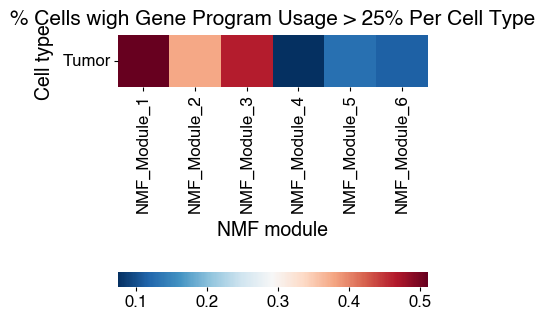

In [17]:
percent_group_usage = usage_norm.groupby(adata.obs['cell_type']).apply(lambda x: (x>0.25).mean())

with mplscience.style_context():
    ax = sns.heatmap(percent_group_usage, cmap = 'RdBu_r', cbar_kws = {'orientation': 'horizontal', 'pad': 0.6})
    ax.set_title('% Cells wigh Gene Program Usage > 25% Per Cell Type')
    ax.set_ylabel('Cell type')
    ax.yaxis.set_tick_params(rotation=0)
    ax.set_xlabel('NMF module')
    ax.set_aspect('equal')
    plt.show()

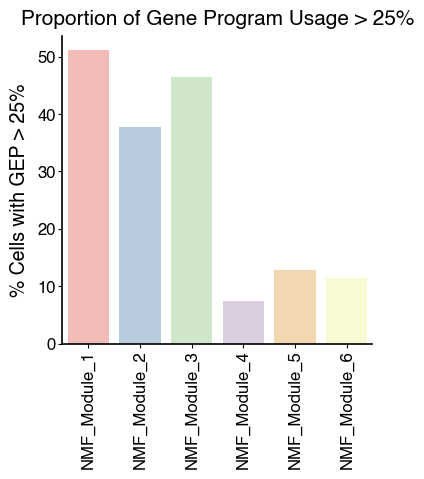

In [18]:

percent_usage = usage_norm.apply(lambda x: (x>0.25).mean())

with mplscience.style_context():
    ax = sns.barplot(percent_usage*100, palette='Pastel1')
    ax.set_title('Proportion of Gene Program Usage > 25%')
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('% Cells with GEP > 25%')
    # plt.savefig(os.path.join(plot_path, 'Fig4D_GEP_proportion_PerCell.pdf'), dpi = 300, format = 'pdf', bbox_inches='tight')
    plt.show()

In [20]:
adata.write('../output/9_annotated_subcluster_embedding_tumor_nmf_added.h5ad')

# StarCAT

In [53]:
import os
import warnings
warnings.simplefilter('ignore')

import starcat
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplscience

In [54]:
tcat = starcat.starCAT(reference = '../output/tumor_only/cNMF/subcluster/subcluster.starcat_spectra.k_6.dt_0_5.txt', cachedir = '../tmp')

Using user specified reference spectra file ../output/tumor_only/cNMF/subcluster/subcluster.starcat_spectra.k_6.dt_0_5.txt
No scores provided


## 1. Allen fetal

In [40]:
adata = sc.read_h5ad('../public/allen_fetal.h5ad')
adata = adata.raw.to_adata()
print(np.max(adata.X))
adata = adata[adata.obs['cell_type'] != 'cell'].copy()
sc.pp.filter_genes(adata, min_cells = 1)
adata.var['gene_id'] = adata.var_names
adata.var.index = adata.var['feature_name']
adata.var

21954.0


,gene_name,feature_name,feature_reference,feature_biotype,feature_length,n_cells,gene_id
feature_name,,,,,,,
Xkr4,Xkr4,Xkr4,NCBITaxon:10090,gene,6094,33821,ENSMUSG00000051951
Gm1992,Gm1992,Gm1992,NCBITaxon:10090,gene,250,12,ENSMUSG00000089699
Gm37381,Gm37381,Gm37381,NCBITaxon:10090,gene,1364,22,ENSMUSG00000102343
Rp1,Rp1,Rp1,NCBITaxon:10090,gene,12311,450,ENSMUSG00000025900
Sox17,Sox17,Sox17,NCBITaxon:10090,gene,4772,3437,ENSMUSG00000025902
...,...,...,...,...,...,...,...
Csprs,Csprs,Csprs,NCBITaxon:10090,gene,2719,23,ENSMUSG00000062783
ENSMUSG00000096808,AC132444.6,ENSMUSG00000096808,NCBITaxon:10090,gene,1500,149,ENSMUSG00000096808
ENSMUSG00000079808,AC168977.1,ENSMUSG00000079808,NCBITaxon:10090,gene,1910,398,ENSMUSG00000079808


In [42]:
mapper = {
    "GABAergic neuron": "neuron",
    "glutamatergic neuron": "neuron",
    "glioblast": "glioblast",
    "oligodendrocyte precursor cell": "oligodendrocyte precursor cell",
    "neural progenitor cell": "neural progenitor cell"
}

adata = adata[adata.obs['cell_type'].isin(['glioblast', 
       'neuron', 'GABAergic neuron',
       'glutamatergic neuron', 'oligodendrocyte precursor cell',
       'neural progenitor cell'])].copy()

adata.obs['cell_type'] = adata.obs['cell_type'].map(mapper).fillna(adata.obs['cell_type'])

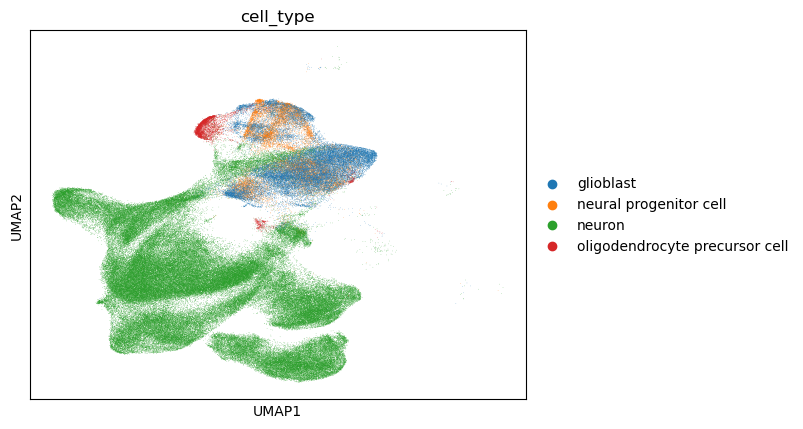

In [43]:
sc.pl.umap(adata, color = 'cell_type')

In [44]:
usage, _ = tcat.fit_transform(adata)
usage.columns = [f'NMF_Module_{i[3:]}' for i in usage.columns]
adata.obs = pd.merge(left=adata.obs, right=usage, how='left', left_index=True, right_index=True)

1921 out of 2000 genes in the reference overlap with the query


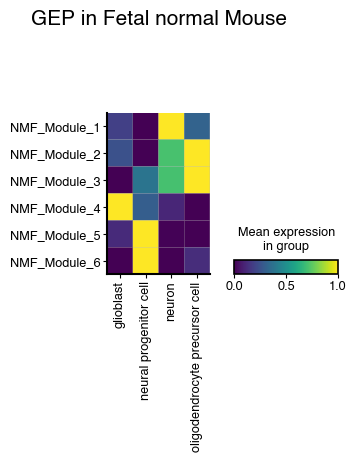

In [45]:
names = [t for t in adata.obs_keys() if t.startswith('NMF_Module')]

with mplscience.style_context():
    sc.pl.matrixplot(adata, names, groupby='cell_type', standard_scale='var', swap_axes=True, title = f"GEP in Fetal normal Mouse", )
    plt.show()

In [46]:
adata.write('../public/allen_fetal_nmf_filtered.h5ad')

## 2. Allen Adult

In [55]:
adata = sc.read_h5ad('../public/allen_adult.h5ad')
adata = adata.raw.to_adata()
print(np.max(adata.X))
adata = adata[adata.obs['cell_type'] != 'cell'].copy()
sc.pp.filter_genes(adata, min_cells = 1)
adata.var['gene_id'] = adata.var_names
adata.var.index = adata.var['feature_name']
adata.var

3304.0


,n_cells,feature_name,feature_reference,feature_biotype,feature_length,gene_id
feature_name,,,,,,
Xkr4,70141,Xkr4,NCBITaxon:10090,gene,6094,ENSMUSG00000051951
Rp1,474,Rp1,NCBITaxon:10090,gene,12311,ENSMUSG00000025900
Sox17,190,Sox17,NCBITaxon:10090,gene,4772,ENSMUSG00000025902
Mrpl15,15722,Mrpl15,NCBITaxon:10090,gene,8487,ENSMUSG00000033845
Lypla1,20587,Lypla1,NCBITaxon:10090,gene,7145,ENSMUSG00000025903
...,...,...,...,...,...,...
Uty,61,Uty,NCBITaxon:10090,gene,9791,ENSMUSG00000068457
Ddx3y,4,Ddx3y,NCBITaxon:10090,gene,5199,ENSMUSG00000069045
Usp9y,486,Usp9y,NCBITaxon:10090,gene,8094,ENSMUSG00000069044


In [56]:
mapper = {
    "inhibitory interneuron": "neuron",
    "medium spiny neuron": "neuron",
    "neuron": "neuron",
    "astrocyte": "astrocyte",
    "oligodendrocyte": "oligodendrocyte",
    "oligodendrocyte precursor cell": "oligodendrocyte precursor cell"
}

adata = adata[adata.obs['cell_type'].isin(['astrocyte', 'oligodendrocyte',
       'inhibitory interneuron', 'neuron',
       'oligodendrocyte precursor cell', 'medium spiny neuron'
       ])].copy()

adata.obs['cell_type'] = adata.obs['cell_type'].map(mapper).fillna(adata.obs['cell_type'])

In [57]:
usage, _ = tcat.fit_transform(adata)
usage.columns = [f'NMF_Module_{i[3:]}' for i in usage.columns]
adata.obs = pd.merge(left=adata.obs, right=usage, how='left', left_index=True, right_index=True)

1837 out of 2000 genes in the reference overlap with the query


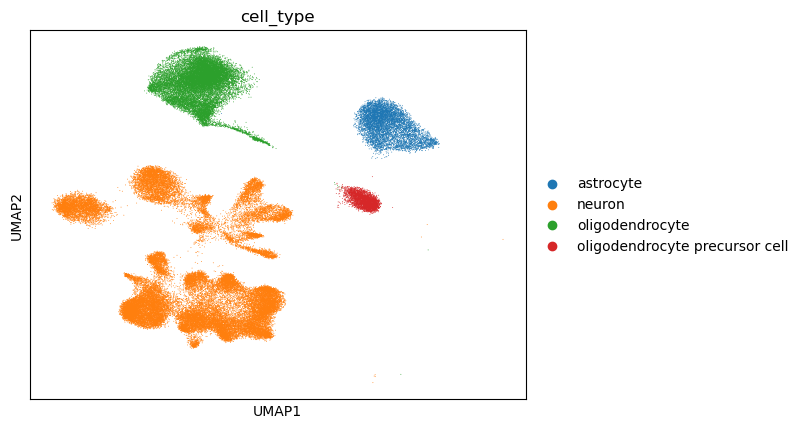

In [58]:
sc.pl.umap(adata, color = 'cell_type')

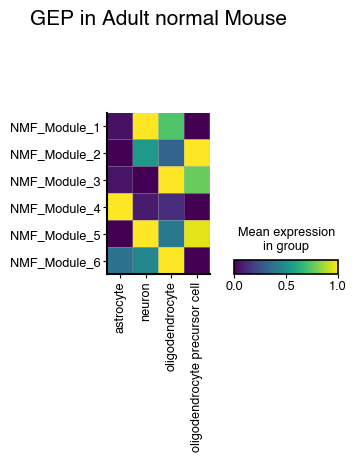

In [59]:
names = [t for t in adata.obs_keys() if t.startswith('NMF_Module')]

with mplscience.style_context():
    sc.pl.matrixplot(adata, names, groupby='cell_type', standard_scale='var', swap_axes=True, title = f"GEP in Adult normal Mouse", )
    plt.show()

In [60]:
adata.write('../public/allen_adult_nmf_filtered.h5ad')

## 3. Enrique - Astrocytoma

In [9]:
adata = sc.read_h5ad('../public/translated/astrocytoma.h5ad')
adata

AnnData object with n_obs × n_vars = 56015 × 17177
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'orig.ident', 'seurat_clusters', 'grade', 'New_NMF_labelling'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_tsne', 'X_umap'
    layers: 'counts'

In [10]:
usage, _ = tcat.fit_transform(adata)
usage.columns = [f'NMF_Module_{i[3:]}' for i in usage.columns]
adata.obs = pd.merge(left=adata.obs, right=usage, how='left', left_index=True, right_index=True)

1672 out of 2000 genes in the reference overlap with the query


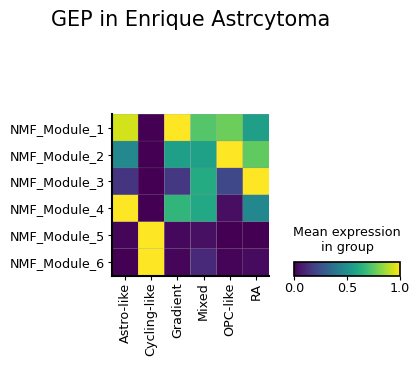

In [11]:
names = [t for t in adata.obs_keys() if t.startswith('NMF_Module')]

with mplscience.style_context():
    sc.pl.matrixplot(adata, names, groupby='New_NMF_labelling', standard_scale='var', swap_axes=True, title = f"GEP in Enrique Astrcytoma", )
    # plt.savefig('../plot/Fig4C_Human_AS_enrique.pdf', dpi = 300, format = 'pdf', bbox_inches='tight')
    plt.show()

## 4. Enrique - Oligodendroglioma

In [12]:
adata = sc.read_h5ad('../public/translated/oligodendroglioma.h5ad')
adata

AnnData object with n_obs × n_vars = 64152 × 17124
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'orig.ident', 'seurat_clusters', 'grade', 'New_NMF_labelling'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'counts'

In [13]:
usage, _ = tcat.fit_transform(adata)
usage.columns = [f'NMF_Module_{i[3:]}' for i in usage.columns]
adata.obs = pd.merge(left=adata.obs, right=usage, how='left', left_index=True, right_index=True)

1674 out of 2000 genes in the reference overlap with the query


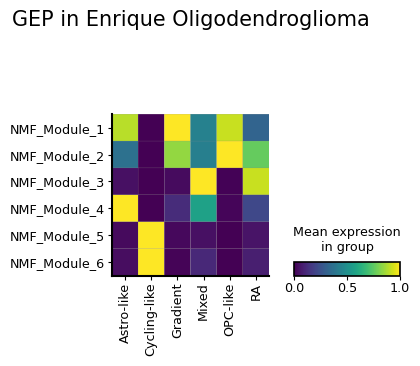

In [14]:
names = [t for t in adata.obs_keys() if t.startswith('NMF_Module')]

with mplscience.style_context():
    sc.pl.matrixplot(adata, names, groupby='New_NMF_labelling', standard_scale='var', swap_axes=True, title = f"GEP in Enrique Oligodendroglioma", )
    # plt.savefig('../plot/Fig4C_Human_OD_enrique.pdf', dpi = 300, format = 'pdf', bbox_inches='tight')
    plt.show()

## 5. Tiroshi - Astrocytoma (GSE89567)

In [15]:
import pickle
with open('../output/tirosh_human_astrocytoma_translated.pkl', 'rb') as f:
    adata = pickle.load(f)

In [16]:
adata = adata[adata.obs.cell_type.isin(['OC-like', 'AC-like', 'stemness', ])].copy()

In [17]:
usage, _ = tcat.fit_transform(adata)
usage.columns = [f'NMF_Module_{i[3:]}' for i in usage.columns]
adata.obs = pd.merge(left=adata.obs, right=usage, how='left', left_index=True, right_index=True)

1645 out of 2000 genes in the reference overlap with the query


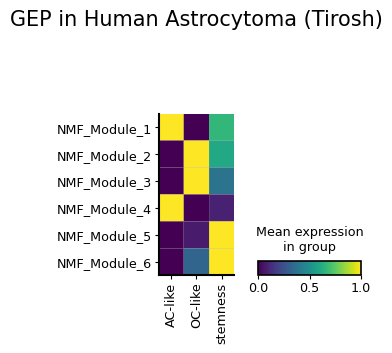

In [18]:
names = [t for t in adata.obs_keys() if t.startswith('NMF_Module')]

with mplscience.style_context():
    sc.pl.matrixplot(adata, names, groupby='cell_type', standard_scale='var', swap_axes=True, title = f"GEP in Human Astrocytoma (Tirosh)", )
    plt.show()

## 6. Tiroshi - Oligodendroglioma (GSE70630)

In [19]:
with open('../output/tirosh_human_oligodendroglioma_translated.pkl', 'rb') as f:
    adata = pickle.load(f)

In [20]:
adata = adata[adata.obs.cell_type.isin(['OC-like', 'AC-like', 'stemness', ])].copy()

In [21]:
usage, _ = tcat.fit_transform(adata)
usage.columns = [f'NMF_Module_{i[3:]}' for i in usage.columns]
adata.obs = pd.merge(left=adata.obs, right=usage, how='left', left_index=True, right_index=True)

1645 out of 2000 genes in the reference overlap with the query


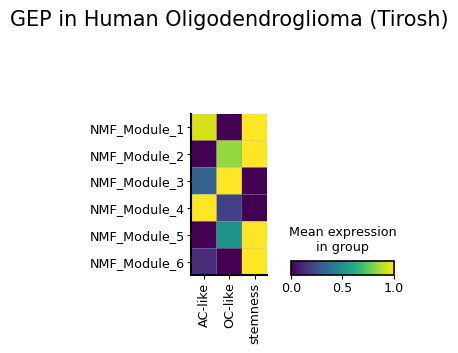

In [22]:
names = [t for t in adata.obs_keys() if t.startswith('NMF_Module')]

with mplscience.style_context():
    sc.pl.matrixplot(adata, names, groupby='cell_type', standard_scale='var', swap_axes=True, title = f"GEP in Human Oligodendroglioma (Tirosh)", )
    plt.show()